## **Segmentation of mitochondria in WebKnossos datasets with Empanada (napari)**
---
Perform segmentation of mitochondria using a pretrained neural network `MitoNet` in `napari`

In [30]:
# Data import
import webknossos as wk
import numpy as np
import zarr
import tifffile as tf

# Napari
import napari
from empanada_napari._volume_inference import volume_inference_widget
import empanada
#viewer = napari.Viewer(show=False) # Runs Napari in headless mode

# Empanada
import os
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage import io


import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm

from empanada.data import VolumeDataset
from empanada.inference.engines import PanopticDeepLabRenderEngine3d
from empanada.inference import filters
from empanada.config_loaders import load_config
from empanada.inference.patterns import *

# Analysis
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create an empty viewer
viewer = napari.Viewer()
# viewer = napari.Viewer(show=False) # Runs Napari in headless mode

In [2]:
def import_wk_dataset_remote(TOKEN, url, dataset_name, organization_id, bbox=None) -> None:
    # use the context to get acces to your group
    with wk.webknossos_context(
        token=TOKEN,
        url=url
    ):

    # open remote dataset with dataset name, organization id and WebKnossos url 
        dataset = wk.Dataset.open_remote(
                dataset_name_or_url = dataset_name,
                organization_id = organization_id,
                webknossos_url = url)
        voxel_size = dataset.voxel_size

        EM = dataset.get_layer("color") # Layer
        mag_view = EM.get_mag(MAG) # MagView
        view = mag_view.get_view(absolute_offset=bbox.topleft, size=bbox.size)
        data = view.read()
        # zarr_array = view.get_zarr_array() 
        # dask_array = da.from_array(zarr_array, chunks=(1, 256, 256, 256))[
        #     (0,) + mag_view.bounding_box.in_mag(MAG).to_slices()]
        
    #return dask_array, zarr_array
    return dataset, data, voxel_size

# if __name__ == "__main__":
#     import_wk_dataset_remote(TOKEN, url, dataset_name, organization_id, bbox=bbox)

def import_wk_dataset_local(dir_path, bbox=None) -> None:
    # open local dataset in given directory 
    dataset = wk.Dataset.open(
        dataset_path = dir_path)
    voxel_size = dataset.voxel_size

    EM = dataset.get_layer("color") # Layer
    mag_view = EM.get_mag(MAG) # MagView

    view = mag_view.get_view(absolute_offset=bbox.topleft, size=bbox.size) # "absolute_offset" and "size" are in Mag(1)!
    data = view.read()
        
    # return data, voxel size
    return dataset, data, voxel_size

def inference_3d(config, volume_data, mode='stack', qlen=3, nmax=20000, seg_thr=0.3, nms_thr=0.1, nms_kernel=3, 
                iou_thr=0.25, ioa_thr=0.25, pixel_vote_thr=2, cluster_io_thr=0.75, min_size=200, 
                min_span=2, downsample_f=1, one_view=True, fine_boundaries=False, use_cpu=True):
                
    # read the model config file
    config = load_config(config)

    # set device and determine model to load
    device = torch.device("cuda:0" if torch.cuda.is_available() and not use_cpu else "cpu")
    use_quantized = str(device) == 'cpu' and config.get('model_quantized') is not None
    model_key = 'model_quantized' if use_quantized  else 'model'
    
    if os.path.isfile(config[model_key]):
        model = torch.jit.load(config[model_key])
    else:
        model = torch.hub.load_state_dict_from_url(config[model_key])

    model = model.to(device)
    model.eval()

    # data
    volume = np.squeeze(volume_data)
    shape = volume.shape

    if mode == 'orthoplane':
        axes = {'xy': 0, 'xz': 1, 'yz': 2} # x, y, z
    else:
        axes = {'yz': 2}

    eval_tfs = A.Compose([
        A.Normalize(**config['norms']),
        ToTensorV2()
    ])

    trackers = {}
    class_labels = list(config['class_names'].keys())
    thing_list = config['thing_list']
    label_divisor = nmax

    # create a separate tracker for
    # each prediction axis and each segmentation class
    trackers = create_axis_trackers(axes, class_labels, label_divisor, shape)

    for axis_name, axis in axes.items():
        print(f'Predicting {axis_name} stack')
        stack = None

        # create the inference engine
        inference_engine = PanopticDeepLabRenderEngine3d(
            model, thing_list=thing_list,
            median_kernel_size=qlen,
            label_divisor=label_divisor,
            nms_threshold=nms_thr,
            nms_kernel=nms_kernel,
            confidence_thr=seg_thr,
            padding_factor=config['padding_factor'],
            coarse_boundaries=not fine_boundaries
        )

        # create a separate matcher for each thing class
        matchers = create_matchers(thing_list, label_divisor, iou_thr, ioa_thr)

        # setup matcher for multiprocessing
        queue = mp.Queue()
        rle_stack = []
        matcher_out, matcher_in = mp.Pipe()
        matcher_args = (
            matchers, queue, rle_stack, matcher_in,
            class_labels, label_divisor, thing_list
        )
        matcher_proc = mp.Process(target=forward_matching, args=matcher_args)
        matcher_proc.start()

        # make axis-specific dataset
        dataset = VolumeDataset(volume, axis, eval_tfs, scale=downsample_f)

        num_workers = 1
        dataloader = DataLoader(
            dataset, batch_size=1, shuffle=False,
            pin_memory=(device == 'gpu'), drop_last=False,
            num_workers=num_workers
        )

        for batch in tqdm(dataloader, total=len(dataloader)):
            image = batch['image']
            size = batch['size']

            # pads and crops image in the engine
            # upsample output by same factor as downsampled input
            pan_seg = inference_engine(image, size, upsampling=downsample_f)

            if pan_seg is None:
                queue.put(None)
                continue
            else:
                pan_seg = pan_seg.squeeze().cpu().numpy()
                queue.put(pan_seg)

        final_segs = inference_engine.end(downsample_f)
        if final_segs:
            for i, pan_seg in enumerate(final_segs):
                pan_seg = pan_seg.squeeze().cpu().numpy()
                queue.put(pan_seg)

        # finish and close forward matching process
        queue.put('finish')
        rle_stack = matcher_out.recv()[0]
        matcher_proc.join()

        print(f'Propagating labels backward through the stack...')
        for index,rle_seg in tqdm(backward_matching(rle_stack, matchers, shape[axis]), total=shape[axis]):
            update_trackers(rle_seg, index, trackers[axis_name])

        finish_tracking(trackers[axis_name])
        for tracker in trackers[axis_name]:
            filters.remove_small_objects(tracker, min_size=min_size)
            filters.remove_pancakes(tracker, min_span=min_span)

    # create the final instance segmentations
    for class_id, class_name in config['class_names'].items():
        print(f'Creating consensus segmentation for class {class_name}...')
        class_trackers = get_axis_trackers_by_class(trackers, class_id)

        # merge instances from orthoplane inference if applicable
        if mode == 'orthoplane':
            if class_id in thing_list:
                consensus_tracker = create_instance_consensus(
                    class_trackers, pixel_vote_thr, cluster_iou_thr, one_view
                )
                filters.remove_small_objects(consensus_tracker, min_size=min_size)
                filters.remove_pancakes(consensus_tracker, min_span=min_span)
            else:
                consensus_tracker = create_semantic_consensus(class_trackers, pixel_vote_thr)
        else:
            consensus_tracker = class_trackers[0]

        dtype = np.uint32 if class_id in thing_list else np.uint8

        # decode and fill the instances
        consensus_vol = np.zeros(shape, dtype=dtype)
        fill_volume(consensus_vol, consensus_tracker.instances)

    print('Finished!')
    return consensus_vol

### **3.1 Configure dataset parameters**
---

In [39]:
TOKEN = "A_KRh0eDGiIuQMTL1EKxWg" # Don't share with others!
url = "https://webknossos.tnw.tudelft.nl"
dataset_name = "20230626_RP_serial"
organization_id = "hoogenboom-group"
dir_path = 'Z:/webknossos/binaryData/hoogenboom-group/20230626_RP_serial'
mag_x, mag_y, mag_z = 16, 16, 1
MAG = wk.Mag(f"{mag_x}-{mag_y}-{mag_z}")

### **3.2 Read data from WebKnossos (remote or local)**
---
Reads data test stack from remote `WebKnossos` dataset

In [37]:
# Read test stack using defined bounding box (coordinates are on full resolution)
bbox = wk.BoundingBox((11904, 11328, 0),(12800,12800,43)).align_with_mag(MAG) # ((x0, y0, z0), (x_size, y_size, z_size)) 34816 × 35840
# bbox = BoundingBox((14697, 17394, 0),(2048,2048,43)).align_with_mag(MAG) # ((x0, y0, z0), (x_size, y_size, z_size))

In [35]:
# For remote access
dataset, data, voxelsize = import_wk_dataset_remote(TOKEN, url, dataset_name, organization_id, bbox=bbox) 
scale_factor = voxelsize[2] / voxelsize[0] / (mag_x / mag_z) # determine scalefactor for viewing
data.shape # Coordinates are (x, y, z), but Napari weirdly reads this as (z, x, y)...

KeyboardInterrupt: 

In [40]:
# For local access
dataset, data, voxelsize = import_wk_dataset_local(dir_path, bbox=bbox) 
scale_factor = voxelsize[2] / voxelsize[0] / (mag_x / mag_z) # determine scalefactor for viewing
data.shape # Coordinates are (x, y, z), but Napari weirdly reads this as (z, x, y)...

(1, 800, 800, 43)

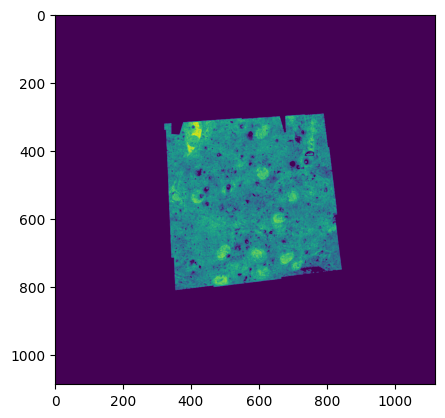

In [26]:
min_data = np.min(np.squeeze(data), 2)
plt.imshow(min_data)


In [29]:
tf.imwrite('min_projection.tif', min_data)

C:\Users\ajkievits\AppData\Local\Temp\ipykernel_10776\1455167540.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tf.imsave('min_projection.tif', min_data)


### 3.2 Add data to `Napari` viewer and run `Empanada`
---
Reads data from remote WebKnossos dataset and performs the segmentation in Napari/Empanada

In [41]:
viewer.add_image(data,
                 scale=(1, 1, 1, scale_factor)) # Use scalefactor for realistic rendering

<Image layer 'data' at 0x1ce58aa97f0>

In [91]:
# Pop up `Empanada` widget
widget = volume_inference_widget()
viewer.window.add_dock_widget(widget, 
                              name="empanada")

### 3.2.1 Alternatively run `Empanada` 3D inference in headless mode
---
Perform 3D inference with `pdl_inference3d.py`

In [97]:
config = os.path.abspath("configs/MitoNet_v1.yaml")

# Run 3d inference
mito_labels = inference_3d(config, data, mode='stack', qlen=1, nmax=20000, seg_thr=0.5, nms_thr=0.1, nms_kernel=3, 
                           iou_thr=0.25, ioa_thr=0.25, pixel_vote_thr=2, cluster_io_thr=0.75, min_size=200, 
                           min_span=2, downsample_f=1, one_view=True, fine_boundaries=False, use_cpu=True)

c:\Users\ajkievits\Miniconda3\envs\mito-seg\lib\site-packages\torch\serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


Predicting yz stack


100%|██████████| 43/43 [03:18<00:00,  4.62s/it]


Propagating labels backward through the stack...


100%|██████████| 43/43 [00:00<00:00, 45.12it/s]


Creating consensus segmentation for class mito...
Finished!


In [100]:
# Check result in Napari
labels_layer = viewer.add_labels(mito_labels, name='headless-segmentation', 
                                scale=(1, 1, scale_factor))

### 3.3 Upload to `WebKnossos`
---
Upload segmentations into a new segmentation layer to `WebKnossos`

In [46]:
# Get labels
label_layer = viewer.layers['data-mito-prediction']
mito_labels = label_layer.data

# Make new "segmentation" layer
segmentation_layer = dataset.add_layer(
        "mito-segmentation", 
        wk.SEGMENTATION_CATEGORY,
        compressed=True,
        largest_segment_id=int(mito_labels.max())
        )
# Add "Mag" and segmentation data to "Mag"
mag = segmentation_layer.add_mag(MAG, compress=True)
mag.write(data=mito_labels,
          absolute_offset=bbox.topleft)
segmentation_layer.downsample(sampling_mode="constant_z")

c:\Users\ajkievits\Miniconda3\envs\napari-env\lib\site-packages\rich\live.py:221: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### 3.4 Analysis 
---
Analyses `label` layer to compute some quick statistics of the labels, for model tuning

In [11]:
# This is for the 2D slice inference 
label_layer = viewer.layers['empanada-2d-seg']
mito_labels = np.squeeze(label_layer.data)

rp_dict = regionprops_table(
    mito_labels,
    properties=['label','bbox','area_bbox']
    )
df = pd.DataFrame(rp_dict)
df.head()

KeyError: "'empanada-2d-seg' is not in list"

In [19]:
# This is for the 3D inference (3D instance segmentation)
label_layer = viewer.layers['data-mito-prediction']
mito_labels = np.squeeze(label_layer.data)
volumes = np.transpose(np.unique(mito_labels, 
                    return_counts=True))
mito_volumes = pd.DataFrame(data=volumes[1:], columns=['label','volume (voxels)']) # Ignore background label which is 0
mito_volumes.head()

,label,volume (voxels)
0,1,340
1,2,757
2,3,549
3,4,3388
4,5,1168


(0.0, 10000.0)

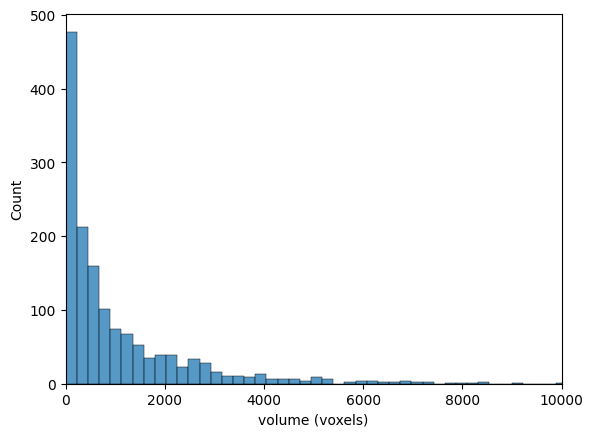

: 

In [44]:
plot1 = sns.histplot(data=mito_volumes,x='volume (voxels)')
plot1.set_xlim([0, 10000])

In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
for i in tqdm(range(int(9e6))):
    pass